Imports

In [28]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pandas as pd
import xgboost as xgb
import numpy as np
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Data binnenhalen:

In [29]:
def get_historical_data_url(ticker):
    unix_oldest_date = 0
    unix_newest_date = int(datetime.now().timestamp())
    return f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={unix_oldest_date}&period2={unix_newest_date}&interval=1d&events=history&includeAdjustedClose=true"


def download_data(ticker):
    url = get_historical_data_url(ticker)
    df = pd.read_csv(url)
    return df

### RSI CALCULATOR


In [30]:
def normalize(df, column="Volume"):
    df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df

#### Gain loss

In [31]:
def get_gain_los(data):
    loss = []
    gain = []
    for i in range(len(data)):
        difference = data[i]-data[i-1]
        if(i != 0):
            if(difference <= 0):
                loss.append(-1 * difference)
            elif(difference > 0):
                gain.append(difference)
    return loss, gain

def get_average_gain_loss(data):
  loss, gain = get_gain_los(data)
  avg_loss = 0
  avg_gain = 0
  if(len(loss) != 0):
    avg_loss = sum(loss)/len(loss)

  if(len(gain) != 0):
    avg_gain = sum(gain)/len(gain)

  return avg_loss, avg_gain

# loss, gain = get_gain_los([20,19,50,45,68,46,65,65,84,52,57,65,98,12,34])
# sum(gain)/len(gain), sum(loss)/len(loss)

#### RSI

In [32]:
def get_rsi(data):
    loss, gain = get_average_gain_loss(data)
    if loss != 0:
      rs = gain / loss
      rsi = 100 - (100 / (1 + rs))
      return rsi
    else:
      return 0

def get_rsi_column(data, count, onlyLast = False):
  rsi_row = []
  for i in range(len(data)):
    i += 1
    start = i - count
    if start < 0:
      start = 0
    rsi_value = (get_rsi(data[start:i]))
    if rsi_value != 0:
      rsi_row.append(rsi_value)
    else:
      rsi_row.append(0)
  return rsi_row


# get_rsi_column([20,19,50,45,68,46,65,65,84,52,57,65,98,32,39], 14)

Berekenen van Bollinger bands

In [33]:
def calculate_boba_row(df,count, onlyLastOne=False):
  data = df.copy()
  if not onlyLastOne:
    data["SMA"] = df['Open'].shift(1).rolling(window=count).mean()
    data["SD"] = df['Open'].shift(1).rolling(window=count).std()    
  elif onlyLastOne:
    data["SMA"] = df['Open'][-count:].mean()
    data["SD"] = df['Open'][-count:].std()
  # Bereken Upper en Lower Bollinger Bands
  upper_band_row = data["SMA"] + (2 * data["SD"])
  lower_band_row = data["SMA"] - (2 * data["SD"])
  return upper_band_row, lower_band_row

Dataframe klaarmaken en ophalen

average volumes berekenen

In [34]:
def calculate_avg_volumes(df, count):
  df['avg_volume'] = df['Volume'].shift(1).rolling(window=count).mean()
  return df

In [35]:
def calculate_avg_open(df, count):
  df['avg_open'] = df['Open'].shift(1).rolling(window=count).mean()
  return df

rsi berekenen

In [36]:
def calculate_rsi_df(df, count, onlyLastOne=False):
    # Bereken de RSI-waarde
    df[f"Rsi{count}"] = get_rsi_column(df["Open"].array,count,onlyLastOne)
    return df

bollinger bands berekenen

In [37]:
def calculate_boba_df(df, count, onlyLastOne=False):
  #Bereken bollinger bands
    df[f"lower_band_{count}"], df[f"upper_band_{count}"] = calculate_boba_row(df,count, onlyLastOne)
    return df

datum naar unix time

In [38]:
def add_features(df):
    df = calculate_avg_volumes(df, 14)
    df = calculate_avg_open(df, 14)
    df = calculate_rsi_df(df, 14)
    df = calculate_boba_df(df, 14)
    return df

In [39]:
def split_train_test(X,y, size=0.8):
  total_size = len(X)

  # Bepaal het indexpunt waar de 80% grens ligt
  split_index = int(size * total_size)

  # Splits de gegevens op basis van de index
  X_train, X_test = X[:split_index], X[split_index:]
  y_train, y_test = y[:split_index], y[split_index:]
  return X_train, X_test, y_train, y_test

In [40]:
def calculcate_dataset_usage(df):
    first_date = df['Date'].min().year
    last_date = df['Date'].max().year
    year_difference = last_date - first_date
    dataset_usage = 1 - 1.1 * year_difference/100
    if dataset_usage < 0.3:
        dataset_usage = 0.3
    elif dataset_usage > 0.95:
        dataset_usage = 1
    return dataset_usage

In [41]:
def get_df_ready(df, dataset_usage_percentage):
  df.index = df['Date']
  df['Date'] = pd.to_datetime(df['Date'])
  if dataset_usage_percentage == None:
    dataset_usage_percentage = calculcate_dataset_usage(df)
  dataset_usage = int(dataset_usage_percentage * len(df))
  print(dataset_usage_percentage)
  df = df[-dataset_usage:]
  df = df.drop("Adj Close", axis=1)
  df = df.drop("High", axis=1)
  df = df.drop("Low", axis=1)
  df = add_features(df)
  df = df.dropna()
  return df

def calculate_axis_close(df):
  X = df.drop(columns=["Close", "Date"])
  y = df["Close"]
  return X, y

def calculate_axis_volume(df):
  X = df[["Volume", "Open"]]
  y = df["Volume"]
  return X, y 

Uitvoeren close predict algoritme

In [42]:
def get_xgboost_close_model(df):
  X, y = calculate_axis_close(df)
  gbm = xgb.XGBRegressor(max_depth=4, n_estimators=200, learning_rate=0.1, eval_metric='rmse', early_stopping_rounds=5)
  gbm.fit(X, y, eval_set=[(X, y)])
  return gbm

def get_xgboost_volume_model(df):
  X, y = calculate_axis_volume(df)
  gbm = xgb.XGBRegressor(max_depth=6, n_estimators=50, learning_rate=0.1, eval_metric='rmse', early_stopping_rounds=5)
  gbm.fit(X, y, eval_set=[(X, y)])
  return gbm

Plotten van voorspelde tov reele waarde (OUD)


In [43]:
def plot_prediction(X_test,y_test,y_pred):
  resultaten = pd.DataFrame({"Date": X_test.index, "Werkelijke": y_test, "Voorspeld": y_pred})
  resultaten = resultaten.sort_values(by="Date")  # Sorteer op tijdstempel als dat nog niet is gebeurd

  # Maak de lijngrafiek
  plt.figure(figsize=(10, 6))
  plt.plot(resultaten["Date"], resultaten["Werkelijke"], label="Werkelijke waarden", marker='o')
  plt.plot(resultaten["Date"], resultaten["Voorspeld"], label="Voorspelde waarden", marker='x')
  plt.xlabel("Datum")
  plt.ylabel("Waarde")
  plt.title("Werkelijke vs Voorspelde waarden")
  plt.xticks(rotation=45)  # Draai de datums voor leesbaarheid
  plt.legend()
  plt.grid(True)

  # Inzoomen op de laatste honderd waarden
  laatste_honderd = resultaten.iloc[-30:]  # Krijg de laatste honderd rijen
  plt.xlim(laatste_honderd["Date"].iloc[0], laatste_honderd["Date"].iloc[-1])  # Stel het bereik van de x-as in
  plt.ylim(150, 200)  # Beperk y-as van 150 tot 200

  plt.tight_layout()
  plt.show()

Retourneert de laatste rij van een gegeven dataframe (als een dataframe)

In [44]:
def get_last_row(X_values):
  row = X_values.iloc[-1:]
  return row

Voorspellen van de standaard features ("Open","Volume","Date")

In [45]:
def next_weekday(date):
    if date.weekday() == 4:
        return date + timedelta(days=3)
    else:
        return date + timedelta(days=1)

In [46]:
def predict_volume_on_new_row(df, volume_model):
  new_row = get_last_row(df)
  new_row["Close"] = new_row["Open"]
  new_row["Date"] = new_row["Date"].apply(next_weekday);
  new_row["Volume"] = volume_model.predict(new_row[["Volume", "Open"]])
  
  # rij toevoegen aan dataframe en dataframe nieuwe features berekenen
  df = pd.concat([df, new_row], ignore_index=True)
  df = add_features(df)
  return df


In [47]:
def predict_open_last_row(df,close_model):
  last_row = get_last_row(df)
  close_prediction = close_model.predict(last_row.drop(["Date", "Close"],axis=1))

  df.loc[df.index[-1], "Open"] = close_prediction[0]
  df.loc[df.index[-2], "Close"] = close_prediction[0]
  return df

Voorspellen van de standaard features van een aantal nieuwe rijen (retourneert alleen de nieuwe rijen als dataframe)

Ik heb dit zo gedaan zodat je kan zien op de grafiek wat de reele waarden zijn en wat de voorspelde waarden zijn


In [48]:
def predict_new_rows(count, df):
   #Het dataframe omzetten naar X & y waardes
  #Model maken adhv X & 
  close_model = get_xgboost_close_model(df)
  volume_model = get_xgboost_volume_model(df)

#print de importance van de features
  plot_importance(volume_model)

  plt.show()
  #Het dataframe omzetten naar X & y waardes
  #Model maken adhv X & y
  #MOdel wordt hier gemaakt omdat je anders altijd een nieuwe rij maakt
  for i in range(count):
    df = predict_volume_on_new_row(df, volume_model)
    df = predict_open_last_row(df,close_model)
  return df

Testen op oude data:

In [49]:
def get_prediction(count, name, dataset_usage_percentage, test):
  df = download_data(name)
  df = get_df_ready(df, dataset_usage_percentage);
  if test:
    prediction = predict_new_rows(count, df[:-count])
  else:
    prediction = predict_new_rows(count, df)  
  return prediction, df

In [50]:
def plot_prediction(prediction, df, back_in_time):
  plt.plot(prediction['Date'].iloc[-back_in_time:],prediction["Open"].iloc[-back_in_time:] , color='r')
  plt.plot(df["Date"].iloc[-back_in_time-10:], df["Open"].iloc[-back_in_time-10:], label="Werkelijke waarden", color='b')
  plt.tight_layout()
  plt.grid()
  plt.show()

In [51]:
def print_new_predictions(count,name, dataset_usage_percentage, test):
  prediction, df = get_prediction(count, name, dataset_usage_percentage, test)
  plot_prediction(prediction, df, count+1)

0.725
[0]	validation_0-rmse:98.60823
[1]	validation_0-rmse:88.95018
[2]	validation_0-rmse:80.24898
[3]	validation_0-rmse:72.40128
[4]	validation_0-rmse:65.34091
[5]	validation_0-rmse:58.96858
[6]	validation_0-rmse:53.22518
[7]	validation_0-rmse:48.05382
[8]	validation_0-rmse:43.39581
[9]	validation_0-rmse:39.20238
[10]	validation_0-rmse:35.41946
[11]	validation_0-rmse:32.01684
[12]	validation_0-rmse:28.95065
[13]	validation_0-rmse:26.18798
[14]	validation_0-rmse:23.69802
[15]	validation_0-rmse:21.46172
[16]	validation_0-rmse:19.45038
[17]	validation_0-rmse:17.64358
[18]	validation_0-rmse:16.02140
[19]	validation_0-rmse:14.56637
[20]	validation_0-rmse:13.26062
[21]	validation_0-rmse:12.08502
[22]	validation_0-rmse:11.03532
[23]	validation_0-rmse:10.10052
[24]	validation_0-rmse:9.26627
[25]	validation_0-rmse:8.52507
[26]	validation_0-rmse:7.86433
[27]	validation_0-rmse:7.27916
[28]	validation_0-rmse:6.75952
[29]	validation_0-rmse:6.30078
[30]	validation_0-rmse:5.88655
[31]	validation_0-r

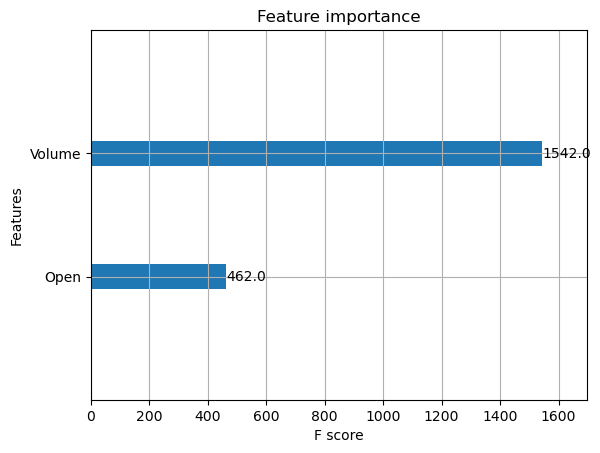

C:\Users\timmo\AppData\Local\Temp\ipykernel_25672\3963892574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Close"] = new_row["Open"]
C:\Users\timmo\AppData\Local\Temp\ipykernel_25672\3963892574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Date"] = new_row["Date"].apply(next_weekday);
C:\Users\timmo\AppData\Local\Temp\ipykernel_25672\3963892574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

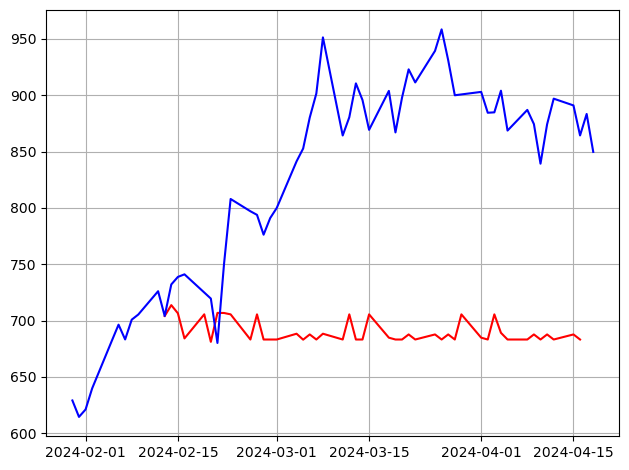

In [52]:
print_new_predictions(45,"NVDA", None, True)

Het printen van de nieuwe voorspelde waardes in een grafiek

0.681
[0]	validation_0-rmse:211.14989
[1]	validation_0-rmse:190.26747
[2]	validation_0-rmse:171.44380
[3]	validation_0-rmse:154.48642
[4]	validation_0-rmse:139.22435
[5]	validation_0-rmse:125.46947
[6]	validation_0-rmse:113.07070
[7]	validation_0-rmse:101.91394
[8]	validation_0-rmse:91.86788
[9]	validation_0-rmse:82.81182
[10]	validation_0-rmse:74.65825
[11]	validation_0-rmse:67.32132
[12]	validation_0-rmse:60.70819
[13]	validation_0-rmse:54.76085
[14]	validation_0-rmse:49.40353
[15]	validation_0-rmse:44.58519
[16]	validation_0-rmse:40.24649
[17]	validation_0-rmse:36.34820
[18]	validation_0-rmse:32.84223
[19]	validation_0-rmse:29.69094
[20]	validation_0-rmse:26.85994
[21]	validation_0-rmse:24.32095
[22]	validation_0-rmse:22.04265
[23]	validation_0-rmse:20.00053
[24]	validation_0-rmse:18.17457
[25]	validation_0-rmse:16.54213
[26]	validation_0-rmse:15.08816
[27]	validation_0-rmse:13.79251
[28]	validation_0-rmse:12.64103
[29]	validation_0-rmse:11.62087
[30]	validation_0-rmse:10.72174
[31]

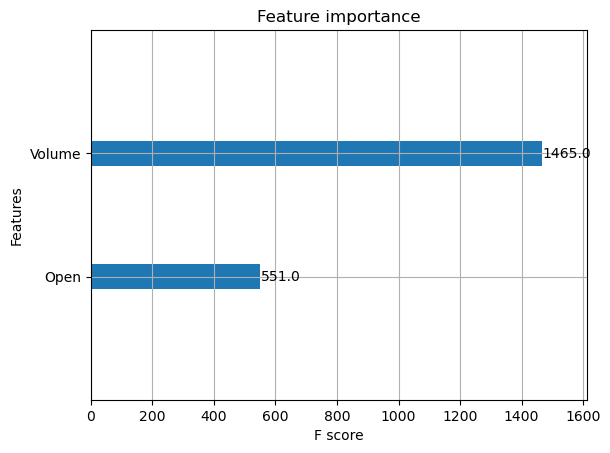

C:\Users\timmo\AppData\Local\Temp\ipykernel_25672\3963892574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Close"] = new_row["Open"]
C:\Users\timmo\AppData\Local\Temp\ipykernel_25672\3963892574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Date"] = new_row["Date"].apply(next_weekday);
C:\Users\timmo\AppData\Local\Temp\ipykernel_25672\3963892574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

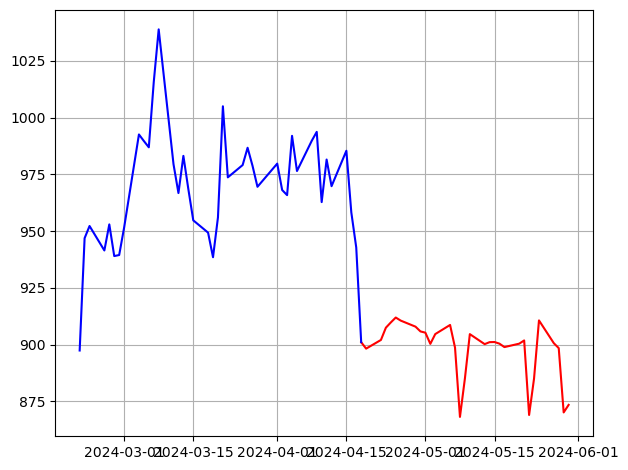

In [54]:
print_new_predictions(30,"ASML", None, False)